# Stats Compass Core - ML & ARIMA Demo

This notebook demonstrates the machine learning and time series (ARIMA) tools.

**Prerequisites:**
```bash
pip install stats-compass-core[ml,timeseries,plots]
```

In [1]:
# Setup
import numpy as np
import pandas as pd

from stats_compass_core import DataFrameState, registry

# Initialize state
state = DataFrameState()

# Discover all tools
registry.auto_discover()
print(f"Loaded {len(registry.list_tools())} tools")
print("\nML tools available:")
for tool in registry.list_tools():
    if tool.category == 'ml':
        print(f"  - {tool.name}")

Loaded 47 tools

ML tools available:
  - fit_arima
  - forecast_arima
  - find_optimal_arima
  - check_stationarity
  - infer_frequency
  - evaluate_classification_model
  - evaluate_regression_model
  - train_gradient_boosting_classifier
  - train_gradient_boosting_regressor
  - train_linear_regression
  - train_logistic_regression
  - train_random_forest_classifier
  - train_random_forest_regressor


---
## Part 1: Classification

Train classifiers on synthetic data and evaluate them.

In [2]:
# Create classification dataset
np.random.seed(42)
n_samples = 500

# Generate features
df_clf = pd.DataFrame({
    'feature_1': np.random.randn(n_samples),
    'feature_2': np.random.randn(n_samples),
    'feature_3': np.random.randn(n_samples),
})

# Create a linearly separable target (with some noise)
df_clf['target'] = (
    (df_clf['feature_1'] * 0.5 + df_clf['feature_2'] * 0.3 + np.random.randn(n_samples) * 0.5) > 0
).astype(int)

state.set_dataframe(df_clf, name='classification_data', operation='create')
print(f"Created classification dataset: {df_clf.shape}")
print(f"\nTarget distribution:\n{df_clf['target'].value_counts()}")
df_clf.head()

Created classification dataset: (500, 4)

Target distribution:
target
1    252
0    248
Name: count, dtype: int64


,feature_1,feature_2,feature_3,target
0,0.496714,0.926178,1.399355,1
1,-0.138264,1.909417,0.924634,1
2,0.647689,-1.398568,0.059630,0
3,1.523030,0.562969,-0.646937,1
4,-0.234153,-0.650643,0.698223,0


In [3]:
# Train Random Forest Classifier
from stats_compass_core.ml.train_random_forest_classifier import (
    TrainRandomForestClassifierInput,
    train_random_forest_classifier,
)

rf_result = train_random_forest_classifier(state, TrainRandomForestClassifierInput(
    dataframe_name='classification_data',
    target_column='target',
    feature_columns=['feature_1', 'feature_2', 'feature_3'],
    test_size=0.2,
    n_estimators=100,
    random_state=42
))

print(f"Model: {rf_result.model_type}")
print(f"Model ID: {rf_result.model_id}")
print(f"Accuracy: {rf_result.metrics}")
print(f"Features: {rf_result.feature_columns}")

Model: random_forest_classifier
Model ID: random_forest_classifier_target_20251211_080944
Accuracy: {'train_score': 1.0, 'test_score': 0.8}
Features: ['feature_1', 'feature_2', 'feature_3']


In [4]:
# Train Logistic Regression for comparison
from stats_compass_core.ml.train_logistic_regression import (
    TrainLogisticRegressionInput,
    train_logistic_regression,
)

lr_result = train_logistic_regression(state, TrainLogisticRegressionInput(
    dataframe_name='classification_data',
    target_column='target',
    feature_columns=['feature_1', 'feature_2', 'feature_3'],
    test_size=0.2,
    random_state=42
))

print(f"Model: {lr_result.model_type}")
print(f"Accuracy: {lr_result.metrics}")


Model: logistic_regression
Accuracy: {'train_score': 0.7975, 'test_score': 0.79}


In [5]:
# Make predictions with the trained model
model = state.get_model(rf_result.model_id)
df_clf['predicted'] = model.predict(df_clf[['feature_1', 'feature_2', 'feature_3']])
state.set_dataframe(df_clf, name='classification_data', operation='add_predictions')
print("Added predictions to DataFrame")

Added predictions to DataFrame


In [6]:
df_clf

,feature_1,feature_2,feature_3,target,predicted
0,0.496714,0.926178,1.399355,1,1
1,-0.138264,1.909417,0.924634,1,1
2,0.647689,-1.398568,0.059630,0,0
3,1.523030,0.562969,-0.646937,1,1
4,-0.234153,-0.650643,0.698223,0,0
...,...,...,...,...,...
495,0.538910,-0.281100,2.006093,1,1
496,-1.037246,1.797687,2.061504,1,1
497,-0.190339,0.640843,1.208366,0,1
498,-0.875618,-0.571179,1.024063,0,0


In [7]:
# Evaluate the classification model
from stats_compass_core.ml.evaluate_classification_model import (
    EvaluateClassificationInput,
    evaluate_classification_model,
)

eval_result = evaluate_classification_model(state, EvaluateClassificationInput(
    dataframe_name='classification_data',
    target_column='target',
    prediction_column='predicted'
))

print(f"Accuracy: {eval_result.accuracy:.4f}")
print(f"Precision: {eval_result.precision:.4f}")
print(f"Recall: {eval_result.recall:.4f}")
print(f"F1 Score: {eval_result.f1:.4f}")
print("\nConfusion Matrix:")
print(f"  {eval_result.confusion_matrix}")

Accuracy: 0.9600
Precision: 0.9610
Recall: 0.9600
F1 Score: 0.9600

Confusion Matrix:
  [[232, 16], [4, 248]]


---
### ROC Curve Visualization

The ROC curve shows the trade-off between true positive rate and false positive rate at various classification thresholds.

In [8]:
# Add probability predictions for ROC curve
# ROC curves need predicted probabilities, not just class predictions
model = state.get_model(rf_result.model_id)
df_clf['prob_positive'] = model.predict_proba(df_clf[['feature_1', 'feature_2', 'feature_3']])[:, 1]
state.set_dataframe(df_clf, name='classification_data', operation='add_probabilities')
print("Added probability predictions")
df_clf[['target', 'predicted', 'prob_positive']].head(10)

Added probability predictions


,target,predicted,prob_positive
0,1,1,0.58
1,1,1,0.94
2,0,0,0.47
3,1,1,1.00
4,0,0,0.05
5,0,0,0.05
6,1,1,0.96
7,1,1,0.98
8,0,0,0.07
9,1,1,0.77


In [9]:
# Generate ROC Curve using the stats-compass-core tool
from stats_compass_core.plots.classification_curves import ROCCurveInput, roc_curve_plot

roc_result = roc_curve_plot(state, ROCCurveInput(
    dataframe_name='classification_data',
    true_column='target',
    prob_column='prob_positive',
    model_id='Random Forest',
    title='ROC Curve - Random Forest Classifier'
))

print(f"AUC Score: {roc_result.auc_score:.4f}")
print(f"Interpretation: {roc_result.interpretation}")

AUC Score: 0.9862
Interpretation: AUC = 0.986 (Excellent). The model correctly ranks a random positive instance higher than a random negative instance 98.6% of the time.


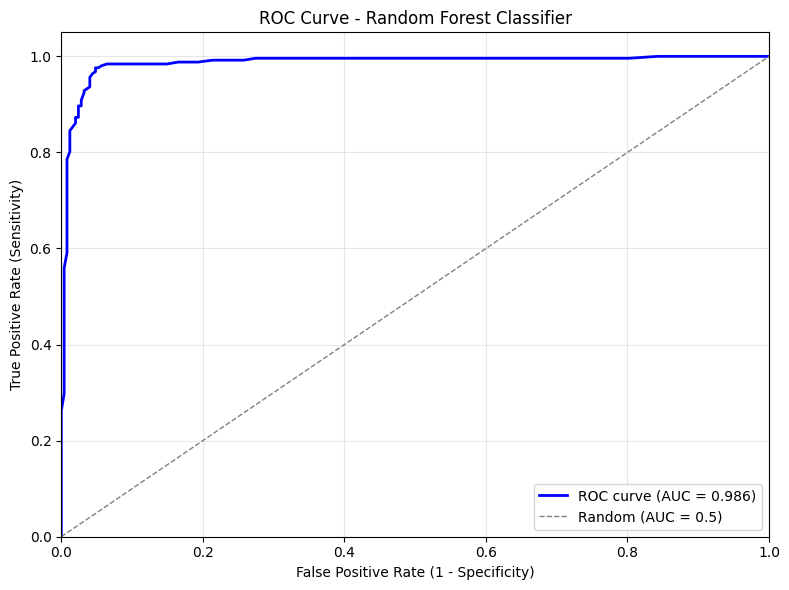

In [10]:
# Display the ROC curve plot
import base64

from IPython.display import Image, display

if roc_result.image_base64:
    img_data = base64.b64decode(roc_result.image_base64)
    display(Image(data=img_data))

---
## Part 2: Regression

Train regression models on synthetic data.

In [11]:
# Create regression dataset
np.random.seed(123)
n_samples = 400

df_reg = pd.DataFrame({
    'sqft': np.random.uniform(500, 3000, n_samples),
    'bedrooms': np.random.randint(1, 6, n_samples),
    'age': np.random.uniform(0, 50, n_samples),
})

# Create price with realistic relationship + noise
df_reg['price'] = (
    df_reg['sqft'] * 150 +
    df_reg['bedrooms'] * 10000 -
    df_reg['age'] * 1000 +
    np.random.randn(n_samples) * 20000
)

state.set_dataframe(df_reg, name='housing_data', operation='create')
print(f"Created regression dataset: {df_reg.shape}")
df_reg.head()

Created regression dataset: (400, 4)


,sqft,bedrooms,age,price
0,2241.172964,1,3.499109,323549.023361
1,1215.348337,1,25.964018,162396.156520
2,1067.128634,5,34.715744,178161.248778
3,1878.286923,5,12.232989,271050.481432
4,2298.672424,1,16.929110,349170.146288


In [12]:
# Train Linear Regression
from stats_compass_core.ml.train_linear_regression import (
    TrainLinearRegressionInput,
    train_linear_regression,
)

lin_result = train_linear_regression(state, TrainLinearRegressionInput(
    dataframe_name='housing_data',
    target_column='price',
    feature_columns=['sqft', 'bedrooms', 'age'],
    test_size=0.2,
    random_state=42
))

print(f"Model: {lin_result.model_type}")
print(f"R²: {lin_result.metrics}")


Model: linear_regression
R²: {'train_score': 0.9699138159194697, 'test_score': 0.971106189203042}


In [13]:
# Train Random Forest Regressor
from stats_compass_core.ml.train_random_forest_regressor import (
    TrainRandomForestRegressorInput,
    train_random_forest_regressor,
)

rf_reg_result = train_random_forest_regressor(state, TrainRandomForestRegressorInput(
    dataframe_name='housing_data',
    target_column='price',
    feature_columns=['sqft', 'bedrooms', 'age'],
    test_size=0.2,
    n_estimators=50,
    random_state=42
))

print(f"Model: {rf_reg_result.model_type}")
print(f"R²: {rf_reg_result.metrics}")


Model: random_forest_regressor
R²: {'train_score': 0.9934976368427622, 'test_score': 0.9583180724817902}


In [14]:
# Evaluate regression model
from stats_compass_core.ml.evaluate_regression_model import (
    EvaluateRegressionInput,
    evaluate_regression_model,
)

# Add predictions first
model = state.get_model(rf_reg_result.model_id)
df_reg['predicted_price'] = model.predict(df_reg[['sqft', 'bedrooms', 'age']])
state.set_dataframe(df_reg, name='housing_data', operation='add_predictions')

reg_eval = evaluate_regression_model(state, EvaluateRegressionInput(
    dataframe_name='housing_data',
    target_column='price',
    prediction_column='predicted_price'
))

print(f"R² Score: {reg_eval.r2:.4f}")
print(f"MAE: ${reg_eval.mae:,.2f}")
print(f"RMSE: ${reg_eval.rmse:,.2f}")

R² Score: 0.9864
MAE: $9,159.89
RMSE: $12,709.38


---
## Part 3: ARIMA Time Series

Fit ARIMA models and generate forecasts.

In [15]:
# Create time series data with trend and seasonality
np.random.seed(42)
n_periods = 120  # 10 years of monthly data

dates = pd.date_range(start='2014-01-01', periods=n_periods, freq='MS')
trend = np.linspace(100, 200, n_periods)
seasonal = 10 * np.sin(np.linspace(0, 10 * np.pi, n_periods))  # ~6 month cycle
noise = np.random.randn(n_periods) * 5

df_ts = pd.DataFrame({
    'date': dates,
    'sales': trend + seasonal + noise
})

state.set_dataframe(df_ts, name='monthly_sales', operation='create')
print(f"Created time series: {df_ts.shape}")
print(f"Date range: {df_ts['date'].min()} to {df_ts['date'].max()}")
df_ts.tail()

Created time series: (120, 2)
Date range: 2014-01-01 00:00:00 to 2023-12-01 00:00:00


,date,sales
115,2023-08-01,189.442474
116,2023-09-01,190.187850
117,2023-10-01,187.437881
118,2023-11-01,202.264343
119,2023-12-01,203.759665


In [16]:
# Check stationarity
from stats_compass_core.ml.arima import StationarityTestInput, check_stationarity

stationarity = check_stationarity(state, StationarityTestInput(
    dataframe_name='monthly_sales',
    target_column='sales'
))


print("\nADF Test:")
print(f"  Statistic: {stationarity[0].test_statistic:.4f}")
print(f"  P-value: {stationarity[0].p_value:.4f}")
print(f"Is stationary: {stationarity[0].is_stationary}")
print(f"\nRecommendation: {stationarity[0].interpretation}")
print("\nKPSS Test:")
print(f"  Statistic: {stationarity[1].test_statistic:.4f}")
print(f"  P-value: {stationarity[1].p_value:.4f}")
print(f"Is stationary: {stationarity[1].is_stationary}")
print(f"\nRecommendation: {stationarity[1].interpretation}")


ADF Test:


/Users/tunjiogunbiyi/Dev/stats-compass-core/.venv-test/lib/python3.12/site-packages/stats_compass_core/ml/arima.py:926: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(series, regression="c", nlags="auto")


TypeError: 'StationarityResult' object is not subscriptable

In [ ]:
# Fit ARIMA model
from stats_compass_core.ml.arima import FitARIMAInput, fit_arima

arima_result = fit_arima(state, FitARIMAInput(
    dataframe_name='monthly_sales',
    target_column='sales',
    date_column='date',
    p=2,  # AR order
    d=1,  # Differencing (for trend)
    q=1,  # MA order
))

print(f"Model ID: {arima_result.model_id}")
print(f"Order: {arima_result.order}")
print(f"AIC: {arima_result.aic:.2f}")
print(f"BIC: {arima_result.bic:.2f}")
print(f"Observations: {arima_result.n_observations}")

In [ ]:
# Generate forecast
from stats_compass_core.ml.arima import ForecastARIMAInput, forecast_arima

forecast = forecast_arima(state, ForecastARIMAInput(
    model_id=arima_result.model_id,
    steps=12,  # Forecast 12 months ahead
    confidence_level=0.95
))

print(f"Forecast for next {len(forecast.forecast_values)} periods:")
for i, (val, lo, hi) in enumerate(zip(
    forecast.forecast_values[:5],
    forecast.lower_ci[:5],
    forecast.upper_ci[:5]
)):
    print(f"  Period {i+1}: {val:.2f} [{lo:.2f}, {hi:.2f}]")
print(f"  ... and {len(forecast.forecast_values) - 5} more")

In [ ]:
# Find optimal ARIMA parameters (auto ARIMA)
from stats_compass_core.ml.arima import FindOptimalARIMAInput, find_optimal_arima

optimal = find_optimal_arima(state, FindOptimalARIMAInput(
    dataframe_name='monthly_sales',
    target_column='sales',
    date_column='date',
    max_p=3,
    max_d=2,
    max_q=3,
    criterion='aic'
))

print(f"Optimal order: {optimal.best_order}")
print(f"Best AIC: {optimal.best_aic:.2f}")
print(f"Models evaluated: {optimal.models_evaluated}")
print("\nTop 3 models:")
for i, model in enumerate(optimal.top_models[:3]):
    print(f"  {i+1}. {model}")

---
## Part 4: Visualization

Plot results using the plotting tools.

In [ ]:
# Plot time series
import base64

from IPython.display import Image, display

from stats_compass_core.plots.lineplot import LinePlotInput, lineplot

line_result = lineplot(state, LinePlotInput(
    dataframe_name='monthly_sales',
    x_column='date',
    y_column='sales',
    title='Monthly Sales Over Time'
))

display(Image(data=base64.b64decode(line_result.image_base64)))

In [ ]:
# Scatter plot: actual vs predicted for regression
from stats_compass_core.plots.scatter_plot import ScatterPlotInput, scatter_plot

scatter_result = scatter_plot(state, ScatterPlotInput(
    dataframe_name='housing_data',
    x='price',
    y='predicted_price',
    title='Actual vs Predicted Price'
))

display(Image(data=base64.b64decode(scatter_result.image_base64)))

In [ ]:
# Feature importance for Random Forest
from stats_compass_core.plots.feature_importance import (
    FeatureImportanceInput,
    feature_importance,
)

fi_result = feature_importance(state, FeatureImportanceInput(
    model_id=rf_result.model_id,
    title='Random Forest Feature Importance'
))

display(Image(data=base64.b64decode(fi_result.image_base64)))
print(f"\nImportance scores: {fi_result.metadata.get('importance_scores', {})}")

---
## State Summary

Review what's stored in state.

In [ ]:
# Check state
summary = state.get_state_summary()

print("=" * 50)
print("STATE SUMMARY")
print("=" * 50)
# Check state
summary = state.get_state_summary()
print(f"DataFrames in state: {len(summary['dataframes'])}")
for name in [df_dict["name"] for df_dict in summary['dataframes']] :
    print(f"  - {name}")
print(f"\nActive DataFrame: {summary["active_dataframe"]}")
print(f"Memory used: {summary['memory']['used_mb']:.2f} MB")

print(f"\nModels ({len(summary['dataframes'])}):")
for model_id in [model_dict["model_id"] for model_dict in summary['models']]:
    print(f"  - {model_id}")

print(f"\nMemory: {summary['memory']['used_mb']:.2f} MB")
print(f"Active DataFrame: {summary['active_dataframe']}")